In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import utils
from tensorflow.keras import losses
from tensorflow.keras import backend as K

import numpy as np 
import pandas as pd
import random

import sys



In [2]:
df_tr = pd.read_csv('/data/cardio4_catboost/df_card_train.csv')
df_t = pd.read_csv('/data/cardio4_catboost/df_card_test.csv')
df_v = pd.read_csv('/data/cardio4_catboost/df_card_valid.csv')
x = df_tr.drop(['y1','y2','y3','y4','w1','w2','w3','w4','ids'],axis=1).to_numpy().astype('int64')
y = df_tr[['y1','y2','y3','y4']].to_numpy().astype('int64')
xt = df_t.drop(['y1','y2','y3','y4','w1','w2','w3','w4','ids'],axis=1).to_numpy().astype('int64')
x_smiles = df_t['ids'].to_numpy()

yt = df_t[['y1','y2','y3','y4']].to_numpy().astype('int64')
xv = df_v.drop(['y1','y2','y3','y4','w1','w2','w3','w4','ids'],axis=1).to_numpy().astype('int64')
 

yv = df_v[['y1','y2','y3','y4']].to_numpy().astype('int64')
input_len = len(x[0])
ytt = [yt[:,0],yt[:,1],yt[:,2],yt[:,3]]
y = {"output_1":y[:,0],"output_2":y[:,1],"output_3":y[:,2],"output_4":y[:,3]}
yv = {"output_1":yv[:,0],"output_2":yv[:,1],"output_3":yv[:,2],"output_4":yv[:,3]}
yt = {"output_1":yt[:,0],"output_2":yt[:,1],"output_3":yt[:,2],"output_4":yt[:,3]}


In [3]:
def set_seed(s):
    K.clear_session()
    
    seed_value= s

    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    
    import random
    random.seed(seed_value)

    import numpy as np
    np.random.seed(seed_value)

    import tensorflow as tf
    tf.random.set_seed(seed_value)


In [4]:
set_seed(17)

In [5]:
def one_specific_layers(x, len1):
    # постобработка для 1 выхода
    y1 = Dense(len1, activation=act)(x)
    y1 = BatchNormalization(momentum=momentum_batch_norm)(y1)
    y1 = Dropout(prob_h2)(y1)

    # STRAIN 2
    y2 = Dense(len1, activation=act)(x)
    y2 = BatchNormalization(momentum=momentum_batch_norm)(y2)
    y2 = Dropout(prob_h2)(y2)
    
    # STRAIN 3
    y3 = Dense(len1, activation=act)(x)
    y3 = BatchNormalization(momentum=momentum_batch_norm)(y3)
    y3 = Dropout(prob_h2)(y3)

    # STRAIN 4
    y4 = Dense(len1, activation=act)(x)
    y4 = BatchNormalization(momentum=momentum_batch_norm)(y4)
    y4 = Dropout(prob_h2)(y4)
    
   
    
    return y1,y2,y3,y4

In [6]:
def two_specific_layers(x, len1, len2):
    # постобработка для 1 выхода
    y1 = Dense(len1, activation=act)(x)
    y1 = BatchNormalization(momentum=momentum_batch_norm)(y1)
    y1 = Dropout(prob_h2)(y1)
    y1 = Dense(len2, activation=act)(y1)
    y1 = BatchNormalization(momentum=momentum_batch_norm)(y1)
    y1 = Dropout(prob_h3)(y1)

    # STRAIN 2
    y2 = Dense(len1, activation=act)(x)
    y2 = BatchNormalization(momentum=momentum_batch_norm)(y2)
    y2 = Dropout(prob_h2)(y2)
    y2 = Dense(len2, activation=act)(y2)
    y2 = BatchNormalization(momentum=momentum_batch_norm)(y2)
    y2 = Dropout(prob_h3)(y2)
    
    # STRAIN 3
    y3 = Dense(len1, activation=act)(x)
    y3 = BatchNormalization(momentum=momentum_batch_norm)(y3)
    y3 = Dropout(prob_h2)(y3)
    y3 = Dense(len2, activation=act)(y3)
    y3 = BatchNormalization(momentum=momentum_batch_norm)(y3)
    y3 = Dropout(prob_h3)(y3)

    # STRAIN 4
    y4 = Dense(len1, activation=act)(x)
    y4 = BatchNormalization(momentum=momentum_batch_norm)(y4)
    y4 = Dropout(prob_h2)(y4)
    y4 = Dense(len2, activation=act)(y4)
    y4 = BatchNormalization(momentum=momentum_batch_norm)(y4)
    y4 = Dropout(prob_h3)(y4)
  
    
    return y1,y2,y3,y4

In [7]:
def build_model(input_len, len1, len2, len3, len4, act, spec_layers,reg):

    # Основная предобработка признакового простанства
    model_input = Input(shape=(input_len,))
    x = Dense(len1, kernel_regularizer=reg,activation=act)(model_input)
    x = BatchNormalization(momentum=momentum_batch_norm)(x)
    x = Dense(len2,kernel_regularizer=reg, activation=act)(x)
    x = BatchNormalization(momentum=momentum_batch_norm)(x)
    x = Dropout(prob_h2)(x)
    x = Dense(len2,kernel_regularizer=reg, activation=act)(x)
    x = BatchNormalization(momentum=momentum_batch_norm)(x)
    x = Dropout(prob_h3)(x)
    x = Dense(len3,kernel_regularizer=reg, activation=act)(x)
    x = BatchNormalization(momentum=momentum_batch_norm)(x)
    x = Dropout(prob_h4)(x)
    
    # Обработка признакового пр-ва для каждого отклика
    if (spec_layers==0):
        y1 = Dense(units=1, activation='sigmoid', name='output_1')(x) # выход без постобработкой
        y2 = Dense(units=1, activation='sigmoid', name='output_2')(x)
        y3 = Dense(units=1, activation='sigmoid', name='output_3')(x)
        y4 = Dense(units=1, activation='sigmoid', name='output_4')(x)
    else:
        if (spec_layers==1):
            y1, y2, y3, y4 = one_specific_layers(x, len3) # выход с постобработкой в один слой
        else:
            if (spec_layers==2):
                y1, y2, y3, y4 = two_specific_layers(x, len3, len4) # выход в 2 слоя

        # Выходы 1 to 5
        y1 = Dense(units=1, activation='sigmoid', name='output_1')(y1)
        y2 = Dense(units=1, activation='sigmoid', name='output_2')(y2)
        y3 = Dense(units=1, activation='sigmoid', name='output_3')(y3)
        y4 = Dense(units=1, activation='sigmoid', name='output_4')(y4)

    model = Model(inputs=model_input, outputs=[y1, y2, y3, y4])
    return model

In [8]:
# для поиска глобального минимума
l_rate = 0.000001
act='relu'
# предотвращение переобучения
prob_h2 = 0.1
prob_h3 = 0.15
prob_h4 = 0.25
momentum_batch_norm = 0.9 # стабилизирует дисперсию
reg = tf.keras.regularizers.l1_l2(0.001,0.001)
model = build_model(input_len,1500,1000,400,10,'relu',0,reg)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1500)         1537500     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1500)         6000        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1000)         1501000     batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
opt = Adam(learning_rate=0.000001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['AUC'])

    

In [11]:
hist = model.fit(x=x, y=y,epochs=500, batch_size=40,validation_data=(xv,yv))#,callbacks=[early_stop])

Epoch 1/500
32/32 [==============================] - 6s 46ms/step - loss: 122.3066 - output_1_loss: 0.9060 - output_2_loss: 0.9000 - output_3_loss: 0.9716 - output_4_loss: 0.9101 - output_1_auc: 0.5200 - output_2_auc_1: 0.5208 - output_3_auc_2: 0.4915 - output_4_auc_3: 0.5443 - val_loss: 121.1097 - val_output_1_loss: 0.5408 - val_output_2_loss: 0.8303 - val_output_3_loss: 0.7819 - val_output_4_loss: 0.3459 - val_output_1_auc: 0.5630 - val_output_2_auc_1: 0.4069 - val_output_3_auc_2: 0.5376 - val_output_4_auc_3: 0.2671
Epoch 2/500
32/32 [==============================] - 0s 13ms/step - loss: 122.3674 - output_1_loss: 0.9324 - output_2_loss: 0.9211 - output_3_loss: 1.0101 - output_4_loss: 0.8994 - output_1_auc: 0.5247 - output_2_auc_1: 0.5179 - output_3_auc_2: 0.4698 - output_4_auc_3: 0.5412 - val_loss: 121.9064 - val_output_1_loss: 0.7839 - val_output_2_loss: 0.9172 - val_output_3_loss: 0.8532 - val_output_4_loss: 0.7547 - val_output_1_auc: 0.5356 - val_output_2_auc_1: 0.3685 - val_outp

In [12]:
from sklearn.metrics import roc_auc_score
pred =model.predict(xt)



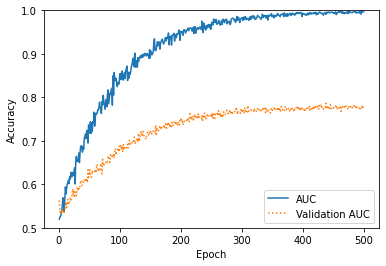

In [14]:
import matplotlib.pyplot as plt
def show_history(hist,a,b):
    acc = hist.history[a]
    val_acc = hist.history[b]
    
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='AUC')
    plt.plot(epochs, val_acc, ':', label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5,1])
    plt.legend(loc='lower right')
    plt.plot()
show_history(hist,'output_1_auc','val_output_1_auc')

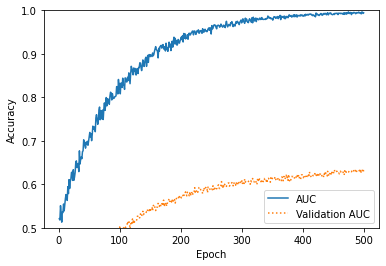

In [15]:
show_history(hist,'output_2_auc_1','val_output_2_auc_1')

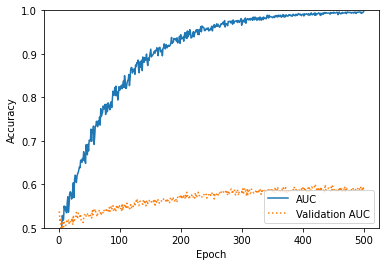

In [16]:
show_history(hist,'output_3_auc_2','val_output_3_auc_2')

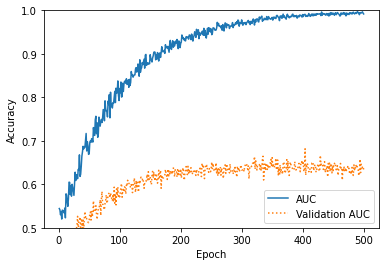

In [17]:
show_history(hist,'output_4_auc_3','val_output_4_auc_3')

In [18]:
roc_auc_score(ytt[0],pred[0])

0.6700020846362309

In [19]:
roc_auc_score(ytt[1],pred[1])

0.6870978120978122

In [20]:
roc_auc_score(ytt[2],pred[2])

0.713301623749385

In [21]:
roc_auc_score(ytt[3],pred[3])

0.6284203980099502

In [23]:
y1 = np.where(pred[0]>0.5,1,0)
y2 = np.where(pred[0]>0.5,1,0)
y3 = np.where(pred[0]>0.5,1,0)
y4 = np.where(pred[0]>0.5,1,0)

In [26]:
df_savey1 = pd.DataFrame(data={'smiles':list(x_smiles)})
df_savey2 = pd.DataFrame(data={'smiles':list(x_smiles)})
df_savey3 = pd.DataFrame(data={'smiles':list(x_smiles)})
df_savey4 = pd.DataFrame(data={'smiles':list(x_smiles)})
df_savey1['y1']=y1
df_savey2['y2']=y2
df_savey3['y3']=y1
df_savey4['y4']=y2
df_savey1.to_csv('output_multi_y1.csv',index=False)
df_savey2.to_csv('output_multi_y2.csv',index=False)
df_savey3.to_csv('output_multi_y3.csv',index=False)
df_savey4.to_csv('output_multi_y4.csv',index=False)
